# DeepFake and DeepFake Detection

#### Face swapping 참고 논문

1. Single Image Face Swapping: [Motion-supervised Co-Part Segmentation](https://arxiv.org/abs/2004.03234)

#### Deepfake detection 참고 논문

1. Deepfake Detection: [FaceForensics++](https://arxiv.org/abs/1901.08971)

## 얼굴 교체 (Face Swapping)

#### Image 한 장으로 DeepFake 동영상 만들기
- Source 와 Target에서 얼굴의 부분들을 분할
- Target Video의 움직임은 그대로 유지하고 Source에서 특정 부분을 가져와 Target Video에 적용하여 Swap

#### 사용할 자료들 불러오기

In [ ]:
#motion supervised segmentation 저자의 공식 github 저장소 자료
%cd /content
!git clone https://github.com/simsimee/motion-cosegmentation

/content
Cloning into 'motion-cosegmentation'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 100 (delta 5), reused 0 (delta 0), pack-reused 90
Receiving objects: 100% (100/100), 42.61 MiB | 3.14 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [ ]:
import gdown #마찬가지로 논문에서 제공된 source와 target

url = 'https://drive.google.com/uc?id=1o5ssXIhm5GlD-sCH7A3TP88AlBt4qFec'
output = 'source.png'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1T5ysutY4Enh0VPzcyfYYCJpyU8Tc8vBP'
output = 'target.mp4'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1o5ssXIhm5GlD-sCH7A3TP88AlBt4qFec
To: /content/source.png
100%|██████████| 130k/130k [00:00<00:00, 40.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1T5ysutY4Enh0VPzcyfYYCJpyU8Tc8vBP
To: /content/target.mp4
100%|██████████| 491k/491k [00:00<00:00, 62.9MB/s]


'target.mp4'

#### 이미지, 동영상 전처리

In [ ]:
import imageio
from skimage.transform import resize

%cd /content

# 이미지와 동영상 불러오기
source_image = imageio.imread('source.png')
reader = imageio.get_reader('target.mp4') # 동영상 리더(reader) 객체 초기화
fps = reader.get_meta_data()['fps']
frames = []

for i in reader: #동영상의 객체를 frames 리스트에 추가
    frames.append(i)
reader.close()

# 이미지와 동영상을 (256 X 256) 해상도로 동일하게 맞춰줌.
source_image = resize(source_image, (256, 256))[..., :3] # 알파값(이미지의 투명도) 제거
frames = [resize(frame, (256, 256)) for frame in frames]

# 해상도 확인하기
print('Source Image 해상도:', source_image.shape)
print('Target Video 해상도:', frames[0].shape)

/content
Source Image 해상도: (256, 256, 3)
Target Video 해상도: (256, 256, 3)


#### 이미지와 동영상을 출력

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# 이미지와 동영상을 출력
def display(source_image, frames, predictions=None):
    fig = plt.figure(figsize=(10 + 5 * (predictions is not None), 5)) # 하나의 그림객체, figsize = (넓이, 높이)
    images = []
    for i in range(len(frames)):
        cols = [source_image] # 왼쪽에는 소스 이미지(image)
        cols.append(frames[i]) # 오른쪽에는 현재의 비디오 프레임(frame)
        if predictions is not None: # 예측 결과가 있는 경우에는 함께 출력
            cols.append(predictions[i])
        image = plt.imshow(np.concatenate(cols, axis=1), animated=True) # 가로를 기준으로 합치기
        images.append([image])

    plt.close()
    ani = animation.ArtistAnimation(fig, images, interval=50, repeat_delay=1000) # 애니메이션(animation) 객체 생성
    return ani

HTML(display(source_image, frames).to_html5_video()) # HTML 비디오(video) 형식으로 화면에 출력

#### Pretrained model, Face parser 불러오기

In [ ]:
%cd motion-cosegmentation

/content/motion-cosegmentation


In [ ]:
import gdown #사전학습모델

url = 'https://drive.google.com/uc?id=1hwW8BjrlHzzG_Z4Z7uhHT73g1XLxO6PN'
output = 'vox-first-order.pth.tar' #공식 file 이름
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1hwW8BjrlHzzG_Z4Z7uhHT73g1XLxO6PN
To: /content/motion-cosegmentation/vox-first-order.pth.tar
751MB [00:03, 188MB/s]


'vox-first-order.pth.tar'

In [ ]:
from part_swap import load_checkpoints #Voxceleb dataset으로 학습된 모델 불러오기

reconstruction_module, segmentation_module = load_checkpoints(config='config/vox-256-sem-10segments.yaml', checkpoint='vox-first-order.pth.tar', blend_scale=0.125, first_order_motion_model=True)
#generator module과 segmetation module

In [ ]:
!git clone https://github.com/simsimee/face-makeup.PyTorch face_parsing

#얼굴을 파싱해주는 face parcer 사용
from part_swap import load_face_parser

face_parser = load_face_parser(cpu=False)

Cloning into 'face_parsing'...
remote: Enumerating objects: 62, done.
remote: Total 62 (delta 0), reused 0 (delta 0), pack-reused 62
Unpacking objects: 100% (62/62), done.


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


#### 이미지 Segmentation

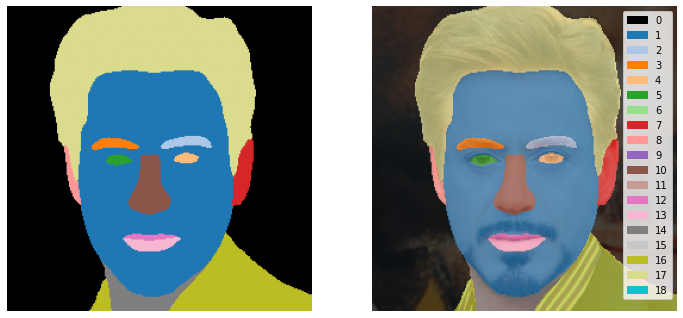

In [ ]:
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore") #경고 메시지 보이지 않도록 하기


# 파싱 네트워크(parsing network)를 이용해 얼굴을 여러 부분으로 분할(segmentation)하여 시각화
def visualize_segmentation(image, network, supervised=False, hard=True, colormap='gist_rainbow'):
    with torch.no_grad():
        # 이미지의 형태를 바꾸어 PyTorch의 Tensor 형태로 변경
        input = torch.tensor(image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2).cuda() #pytorch는 채널이 앞에 있어서 permute를 이용해 순서를 바꿔줌. [batch_size, channel, height, width]
        input = F.interpolate(input, size=(512, 512)) #interpolate로 scailing
        input = (input - network.mean) / network.std # 정규화
        mask = torch.softmax(network(input)[0], dim=1) # 네트워크에 입력하여 마스크 확인
        mask = F.interpolate(mask, size=image.shape[:2]) # 마스크와 input을 같은 크기로 맞춰줌

    if hard:
        mask = (torch.max(mask, dim=1, keepdim=True)[0] == mask).float() 

    # 마스크를 알아보기쉽게 색상을 넣어줌
    colormap = plt.get_cmap(colormap)
    num_segments = mask.shape[1]
    mask = mask.squeeze(0).permute(1, 2, 0).cpu().numpy() # batch size 없애고 다시 이미지 permute로 height, width, channel 순으로 변경 
    color_mask = 0
    patches = []

    # segment마다 각각 다른 색 적용
    for i in range(num_segments):
        if i != 0:
            color = np.array(colormap((i - 1) / (num_segments - 1)))[:3]
        else:
            color = np.array((0, 0, 0))
        patches.append(mpatches.Patch(color=color, label=str(i)))
        color_mask += mask[..., i:(i + 1)] * color.reshape(1, 1, 3)
    
    # 두 장의 이미지가 담길 수 있는 그림(figure) 생성
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(color_mask)
    ax[1].imshow(0.3 * image + 0.7 * color_mask)
    ax[1].legend(handles=patches)
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

visualize_segmentation(source_image, face_parser, supervised=True, hard=True, colormap='tab20')

#### Segmentation에 따른 Target 영상 Face Swapping

In [ ]:
from part_swap import make_video # /motion-cosegmentation/part_swap.py 의 make_video 함수

predictions = make_video(swap_index=[17], source_image=source_image, #머리에 해당하는 index만 지정하여 머리만 변경.
                         target_video=frames, use_source_segmentation=True, segmentation_module=segmentation_module,
                         reconstruction_module=reconstruction_module, face_parser=face_parser)

HTML(display(source_image, frames, predictions).to_html5_video())

100%|██████████| 211/211 [00:14<00:00, 14.88it/s]


In [ ]:
predictions = make_video(swap_index=[1], source_image=source_image, #얼굴의 피부만 변경했을 때
                         target_video=frames, use_source_segmentation=True, segmentation_module=segmentation_module,
                         reconstruction_module=reconstruction_module, face_parser=face_parser)

HTML(display(source_image, frames, predictions).to_html5_video())

100%|██████████| 211/211 [00:14<00:00, 14.97it/s]


In [ ]:
# 얼굴 전체를 변경.
predictions = make_video(swap_index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], source_image=source_image,
                         target_video=frames, use_source_segmentation=True, segmentation_module=segmentation_module,
                         reconstruction_module=reconstruction_module, face_parser=face_parser)

HTML(display(source_image, frames, predictions).to_html5_video())

100%|██████████| 211/211 [00:14<00:00, 14.97it/s]


In [ ]:
#결과 저장
from skimage import img_as_ubyte

imageio.mimsave('./face_swapping.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)

## 딥페이크 탐지 (DeepFake Detection)

#### 사용할 모델 불러오기

In [1]:
%cd /content/ #논문 저자의 공식 github
!git clone https://github.com/simsimee/FaceForensics

[Errno 2] No such file or directory: '/content/ #논문 저자의 공식 github'
/content
Cloning into 'FaceForensics'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 382 (delta 0), reused 0 (delta 0), pack-reused 378
Receiving objects: 100% (382/382), 59.80 MiB | 27.00 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [2]:
!pip install pretrainedmodels==0.7.4 #사전훈련모델

     |████████████████████████████████| 58 kB 3.6 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=7cf5b8ad83cf309caf9025dc9df513e9c06c4a94e6a309293e0c5da8456b651b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [3]:
!mkdir -p /home/ondyari/.torch/models

In [4]:
import gdown #xception 모델

# 다운로드받을 파일이 존재하는 URL
url = 'https://drive.google.com/uc?id=1PDGYCwVv-ANPHEFzbDKo9rPmhAFRxrrM'

# 저장할 파일 이름
output = '/home/ondyari/.torch/models/xception-b5690688.pth'
gdown.download(url, output, quiet=True)

'/home/ondyari/.torch/models/xception-b5690688.pth'

In [5]:
import gdown #xception 모델

# 다운로드받을 파일이 존재하는 URL
url = 'https://drive.google.com/uc?id=1UZJhXD-txlwq2d0aEziP8PctnUd5124P'

# 저장할 파일 이름
output = 'source.png'
gdown.download(url, output, quiet=True)

'source.png'

In [6]:
%%capture 
!wget http://kaldir.vc.in.tum.de/FaceForensics/models/faceforensics++_models.zip -O faceforensics_models.zip
!unzip faceforensics_models.zip -d ./

#### bounding box

In [7]:
import dlib #detection library
import cv2
import matplotlib.pyplot as plt


def get_boundingbox(face, width, height, scale=1.3):
    x1 = face.left() 
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale) # 바운딩 박스 크기를 좀 더 크게 만들어줌
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # 왼쪽 위 좌표
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # 넓이 - x1, 높이 - y1 과 bounding box 사이즈 중 작은것을 바운딩 박스로 설정.
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

#### 이미지 전처리

In [8]:
import sys

sys.path.insert(0, "/content/FaceForensics/classification")

In [9]:
from PIL import Image
from dataset.transform import xception_default_data_transforms


def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR 순서를 RGB 순서로 변환
    preprocess = xception_default_data_transforms['test'] #네트워크의 test 전처리함수를 가져옴.
    preprocessed_image = preprocess(Image.fromarray(image)) # PIL image 객체로 바꾼 뒤에 PyTorch 객체로 변환
    preprocessed_image = preprocessed_image.unsqueeze(0).cuda() #pytorch 형식 [channel, height, with ] → [1, channel, height, width] unsqueeze로 batch size를 추가해준 뒤 cuda로 gpu로 넣어줌.

    return preprocessed_image

#### 모델을 불러온 후 예측하기

In [10]:
import torch.nn as nn
import torch
from network.models import model_selection
import warnings
warnings.filterwarnings("ignore") #경고 메시지 보이지 않도록 하기

model_path = 'faceforensics++_models_subset/full/xception/full_raw.p'

# 모델 불러오기(model loading)
model, *_ = model_selection(modelname='xception', num_out_classes=2) #Real or Fake 2 class
model = torch.load(model_path)
model = model.cuda() #model을 gpu에 올려줌.

In [11]:
def predict_with_model(image, model, post_function=nn.Softmax(dim=1)):
    # 전처리(preprocess) 수행
    preprocessed_image = preprocess_image(image)

    # 모델 예측
    output = model(preprocessed_image)
    output = post_function(output)

    # 결과와 확률 값을 반환
    _, prediction = torch.max(output, 1)
    prediction = float(prediction.cpu().numpy())

    return int(prediction), output

#### 이미지 딥페이크 예측

판별 결과: Real
확률 값 출력: ['0.85', '0.15']


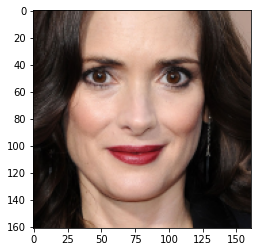

[ 이미지에 판별 결과 그리기 ]


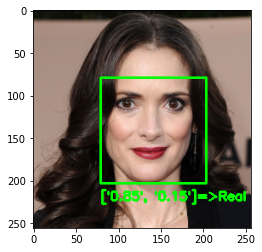

In [12]:
image = cv2.imread("./source.png")

def deep_det(image):
  image = cv2.resize(image, dsize=(256,256), interpolation=cv2.INTER_LINEAR)
  face_detector = dlib.get_frontal_face_detector()
  face = face_detector(image) # 얼굴 탐지 수행
  face = face[0] # 이미지 내에서 첫 번째 얼굴 선택

  height, width = image.shape[:2]
  x, y, size = get_boundingbox(face, width, height) # 바운딩 박스(bounding box) 찾기
  cropped = image[y:y + size, x:x + size]

  prediction, output = predict_with_model(cropped, model)
  label = 'Fake' if prediction == 1 else 'Real' 
  output_list = ['{0:.2f}'.format(float(x)) for x in output.detach().cpu().numpy()[0]]

  print("판별 결과:", label)
  print("확률 값 출력:", output_list)
  plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
  plt.show()

  x = face.left()
  y = face.top()
  w = face.right() - x
  h = face.bottom() - y

  font_face = cv2.FONT_HERSHEY_SIMPLEX
  thickness = 2
  font_scale = 0.5
  color = (0, 255, 0) if prediction == 0 else (0, 0, 255)

  print("[ 이미지에 판별 결과 그리기 ]")
  # 판별 결과를 텍스트 형태로 그리기
  cv2.putText(image, str(output_list) + '=>' + label, (x, y + h + 20), font_face, font_scale, color, thickness, 2)

  # 얼굴 주위로 바운딩 박스(bounding box) 그리기
  cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)

  # 바운딩 박스가 포함된 이미지 그리기
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

deep_det(image)

#### 동영상 딥페이크 예측

In [13]:
import os
from os.path import join

def vdeep_det(video_path):
  model_path = 'faceforensics++_models_subset/full/xception/full_raw.p'
  output_path = 'detection_output'

  # 원본 영상을 읽기 위한 Reader 객체
  reader = cv2.VideoCapture(video_path)

  video_fn = video_path.split('/')[-1].split('.')[0] + '.avi' # avi 파일로 저장
  os.makedirs(output_path, exist_ok = True)
  fourcc = cv2.VideoWriter_fourcc(*'MJPG')
  fps = reader.get(cv2.CAP_PROP_FPS) # 원본 영상의 FPS
  num_frames = int(reader.get(cv2.CAP_PROP_FRAME_COUNT)) # 원본 영상의 전체 프레임 개수
  writer = None

  # dlib 얼굴 탐지 라이브러리
  face_detector = dlib.get_frontal_face_detector()

  # 텍스트 출력 관련 변수
  font_face = cv2.FONT_HERSHEY_SIMPLEX
  thickness = 1
  font_scale = 0.3
  fake_score=[]

  # 동영상 Reader 객체가 없을 때까지 반복
  while reader.isOpened():
      # 동영상에서 현재의 프레임 캡처
      _, image = reader.read()
      if image is None:
          break

      image = cv2.resize(image, dsize=(256,256), interpolation=cv2.INTER_NEAREST)
      # 이미지 크기 받아오기
      height, width = image.shape[:2]

      if writer is None:
          writer = cv2.VideoWriter(join(output_path, video_fn), fourcc, fps, (height, width)[::-1])

      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      faces = face_detector(gray, 1)

      # 최소한 1개 이상의 얼굴이 탐지 된 경우
      if len(faces):
          # 가장 큰 얼굴(the biggest face)만 사용하기
          face = faces[0]

          x, y, size = get_boundingbox(face, width, height)
          cropped_face = image[y:y + size, x:x + size]

          prediction, output = predict_with_model(cropped_face, model)
          label = 'Fake' if prediction == 1 else 'Real'
          output_list = ['{0:.2f}'.format(float(x)) for x in output.detach().cpu().numpy()[0]]
          fake_score.append(output_list[1])

          # 출력용 변수 초기화
          x = face.left()
          y = face.top()
          w = face.right() - x
          h = face.bottom() - y

          color = (0, 255, 0) if prediction == 0 else (0, 0, 255)

          # 판별 결과를 텍스트 형태로 그리기
          cv2.putText(image, str(output_list) + '=>' + label, (x, y + h + 20), font_face, font_scale, color, thickness, 2)

          # 얼굴 주위로 바운딩 박스(bounding box) 그리기
          cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)

      # 처리된 이미지를 결과 영상에 쓰기
      writer.write(image)
  fake_score = [float(i) for i in fake_score]
  fake_score = sum(fake_score, 0.0) / len(fake_score)
  print('Fake일 확률 =', fake_score*100,'%')

vdeep_det('face_swapping.mp4')

Fake일 확률 = 49.19905213270139 %


In [ ]:
vdeep_det('fake_video.mp4')

Fake일 확률 = 53.95462184873946 %


In [ ]:
vdeep_det('fake_video2.mp4')

Fake일 확률 = 96.85333333333382 %


#### mp4파일로 변형

In [ ]:
!ffmpeg -i detection_output/face_swapping.avi detection_output/face_swapping.mp4

In [ ]:
!ffmpeg -i detection_output/fake_video.avi detection_output/fake_video.mp4

In [ ]:
!ffmpeg -i detection_output/fake_video2.avi detection_output/fake_video2.mp4

#### 동영상 출력하기

In [17]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('detection_output/face_swapping.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()

# Google Colab 화면에 출력
HTML(f"<video width=400 controls> <source src='{data_url}' type='video/mp4'> </video>")

In [ ]:
mp4 = open('detection_output/fake_video.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()

# Google Colab 화면에 출력
HTML(f"<video width=400 controls> <source src='{data_url}' type='video/mp4'> </video>")

In [ ]:
mp4 = open('detection_output/fake_video2.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()

# Google Colab 화면에 출력
HTML(f"<video width=400 controls> <source src='{data_url}' type='video/mp4'> </video>")